<a href="https://colab.research.google.com/github/adeepH/DravidianOffensive/blob/main/Notebooks/CM-TRA/Kannada/XLM-R-base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers==3.3.1

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [7]:
!git clone https://github.com/adeepH/DravidianOffensive.git

fatal: destination path 'DravidianOffensive' already exists and is not an empty directory.


In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [9]:
train=pd.read_csv('/content/DravidianOffensive/Datasets/Pseudo Labels/Pseudo_kan.csv')
train['labels']=LabelEncoder().fit_transform(train['labels']) 
#for i in range(len(train)):
#  train['tweets'][i]=train['tweets'][i][8:-2]
train=train.drop(columns=['Unnamed: 0'])
train

,tweets,labels
0,Tik tok alli jagala madtidralla adra baggenu o...,0
1,Anyone from kerala here,5
2,Movie rerelease madi plss,0
3,Amazon prime alli bittidira....yella manele no...,0
4,Guru sure news nanu tik tok dawn lod madeda ya...,0
...,...,...
14761,{'kn': '1ಎಟ್ ತೆಲೆಗ್ರಾಂ ಅಪ್ಪಿ ಕ್ಲೋಸ್ ಮಾಡ್ಸಿ ಆಮೇ...,0
14762,{'kn': 'ಸೂಪರ್ ತೊಗರಿ ಟಿಪ್ಪ'},0
14763,ಭಾರತ್ರಜ್ ತ್ ಬಿಎ ಕಿಟ್ಕೋಬೇಕಷ್ಟೆ ನೀನು ಬಂದಿ ನಂದು,0
14764,{'kn': 'ರಶ್ಮಿಕ ಎಲ್ಲಿಡ್ಡೆಯಕ್ಕ🤣🥀ನಂಕ್ರಾಕ್ಷಿತ್ ಶೆಟ...,0


In [10]:
train.labels.value_counts()

0    11437
5     1751
2      820
1      374
4      245
3      139
Name: labels, dtype: int64

In [11]:
val=pd.read_csv('/content/DravidianOffensive/Datasets/Trans_kan_test.csv')
val['labels']=LabelEncoder().fit_transform(val['label'])
val['tweets']=val['Sentence']
for i in range(len(val)):
  val['tweets'][i]=val['tweets'][i][8:-2]
val=val.drop(columns=['label','Unnamed: 0','transliterated','Sentence'])
val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,labels,tweets
0,1,ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗು
1,1,e vedio nodinu mathe chaina apps use madidre....
2,0,na yenu thappila yela sari agi hellidira sup
3,5,r super super super sup
4,5,(KANNADA RAP 201
...,...,...
773,0,start maadalu capacity growth maadalu tips kod...
774,2,idanna nodi thi*a urkimbeku🤣🤣🤣
775,5,ou s
776,0,ೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗ


In [12]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,tweets,labels,tokenizer,max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self,item):
    tweets = str(self.tweets[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'tweets' : tweets,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'labels' : torch.tensor(labels,dtype=torch.long)

    }

In [13]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (14766, 2)
validation set size: (778, 2)


In [14]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([ 0.21517881,  6.5802139 ,  3.00121951, 17.70503597, 10.04489796,
        1.40548258])

In [15]:
def create_data_loader(df,tokenizer,max_len,batch_size,shuffle=True):
  ds = RFDataset(
      tweets = df.tweets.to_numpy(),
      labels = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    num_workers=4)

In [16]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [17]:
BATCH_SIZE = 64
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('xlm-roberta-base')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [28]:
model =RFClassifier(5)
model = model.to(device)

In [29]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [30]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
 
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

if train_acc > best_accuracy:
    best_accuracy = train_acc
torch.save(model.state_dict(),'distilbert-base-multilingual-cased.bin')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01 | Epoch Time: 3m 1s
Train Loss 1.017812677663126 accuracy 0.7653392929703373
Val Loss 1.2911284061578603 accuracy 0.48329048843187655

Epoch: 02 | Epoch Time: 3m 1s
Train Loss 0.584493136380142 accuracy 0.8120682649329541
Val Loss 1.0476160553785472 accuracy 0.6491002570694087

Epoch: 03 | Epoch Time: 3m 1s
Train Loss 0.5159899393717448 accuracy 0.8348232425843154
Val Loss 1.0137221217155457 accuracy 0.659383033419023

Epoch: 04 | Epoch Time: 3m 1s
Train Loss 0.4809371770331354 accuracy 0.8465393471488555
Val Loss 0.9992907551618723 accuracy 0.652956298200514

Epoch: 05 | Epoch Time: 3m 2s
Train Loss 0.45456051652307633 accuracy 0.8540566165515373
Val Loss 0.9932205631182744 accuracy 0.6555269922879177



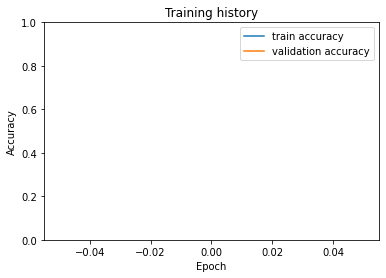

In [25]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [26]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

NameError: ignored

In [27]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweets"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [35]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [36]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred,zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.6889    0.7728    0.7285       427
           1     0.0000    0.0000    0.0000        44
           2     0.6316    0.1600    0.2553        75
           3     0.0000    0.0000    0.0000        14
           4     0.0000    0.0000    0.0000        33
           5     0.6000    0.9081    0.7226       185

    accuracy                         0.6555       778
   macro avg     0.3201    0.3068    0.2844       778
weighted avg     0.5817    0.6555    0.5963       778

